In [1]:
# ensure we run on the CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Couplings J1 and J2
J = [1, 0.8]
L = 14

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

In [4]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [5]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [6]:
# Custom Hamiltonian operator
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

FFNN =  fully connected feedforward neural network nk.machine.FFNN

In [7]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x
        
model = FFNN()

In [8]:
# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

# Construct the variational state
vs = nk.vqs.MCState(sa, model, n_samples=1008)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.01)

# We can then specify a Variational Monte Carlo object, using the Hamiltonian, sampler and optimizers chosen.
# Note that we also specify the method to learn the parameters of the wave-function: here we choose the efficient
# Stochastic reconfiguration (Sr), here in an iterative setup
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [9]:
# We need to specify the local operators as a matrix acting on a local Hilbert space 
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

In [19]:
# Run the optimization protocol
gs.run(out='logs/n_14_1_0_0_8_test', n_iter=600, obs={'Structure Factor': structure_factor})

100%|███████████████████████████████████████████████████| 600/600 [02:28<00:00,  4.03it/s, Energy=-23.417+0.050j ± 0.087 [σ²=7.715, R̂=0.9929]]


(JsonLog('logs/n_14_1_0_0_8_test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.2936718463897705
   	Params: 0.0032739639282226562,)

In [20]:
# Load the data from the .log file
import json

data=json.load(open("logs/n_14_1_0_0_8_test.log"))

iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

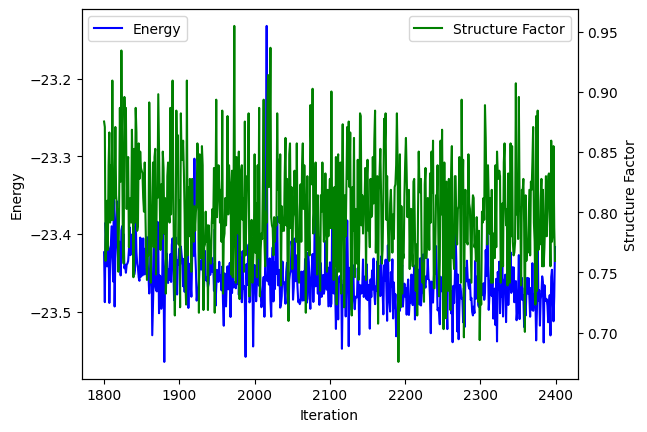

In [21]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [22]:
print(r"Structure factor = {0:.3f}({1:.3f})".format(np.mean(sf[-50:]),
                                              np.std(np.array(sf[-50:]))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Structure factor = 0.798(0.006)
Energy = -23.480(0.004)


In [23]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]

In [24]:
print("Exact Ground-state Structure Factor: {0:.3f}".format(structure_factor_gs))
print("Exact ground state energy = {0:.3f}".format(E_gs[0]))

Exact Ground-state Structure Factor: 0.518
Exact ground state energy = -23.807
